# Table of Contents

1. Data Preprocessing

2. Feature Engineering

3. Model Building

4. Model Evaluation (make prediciton on the holdout dataset as well)

5. Prediction Interpretation

6. Recommendation

---

In [1060]:
# import libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
# import tensorflow as tf
# from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from xgboost import XGBClassifier




In [1027]:
import importlib
importlib.reload(ynk)
from utils import you_never_know_where_it_is as ynk
from utils.you_never_know_where_it_is import DataPreprocessor, PerformanceMetrics


# I. Data Preprocessing

In [1028]:
df = pd.read_csv('./data/loan_train.csv')

Let's write a class to write all the data preprocessing steps.

Some plot functions

## I.1 Basic Overview Analysis

Eyeball data, check missing values, duplicates

In [1029]:
# df.info()


`Check duplicates`

In [1030]:
# check duplicates
df.duplicated().sum()

# remove duplicates 
df = df.drop_duplicates()


`Check missing values`

In [1031]:
# missing values as a percentage
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values = missing_values / len(df) * 100
missing_values = missing_values.sort_values(ascending=False)

In [1032]:
# number of missing cols containing missing values
print('number of cols containing missing values:', len(missing_values))

# number of missing values in the loan_status 
print('number of missing values in the loan_status:', df['loan_status'].isnull().sum())

number of cols containing missing values: 51
number of missing values in the loan_status: 0


Apparently, all cols contain missing values except the label. This is quite annoying

Here is the plan to deal with missing values:
- if the missing values are less than 1% of the total, we can drop the rows 

- if the missing values are less than 10% of the total we can do some further investigation to see if it's appropriate to fill these missing values with median or mode 

- If the missing values are greater than 10%, let's investigation to see if there is a reason for the missing values. If not, we can decide to drop some cols wikth extremely high missing values

In [1033]:
# get the index for those have value less than 1% in missing_values
small_missing_values= missing_values[missing_values < 1].index

small_missing_values.tolist()

# drop the rows with missing values in the small_missing_values
df = df.dropna(subset=small_missing_values)

In [1034]:
# check the remaining missing values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values = missing_values / len(df) * 100
missing_values = missing_values.sort_values(ascending=False)
missing_values

next_pymnt_d              92.307172
mths_since_last_record    91.593369
mths_since_last_delinq    63.606225
desc                      31.725304
emp_title                  6.062246
pub_rec_bankruptcies       2.919486
emp_length                 2.547361
dtype: float64

These faetures are a bit complicated, and require careful handling. Thus, we will take care of them in **feature engineering** 

## I.2 Univariate Analysis

In [1035]:
# initialize the DataPreprocessor
dp = DataPreprocessor()

### I.2.1 Numerical Features

Visualize histogram of all these numerical features to see the distribution of the data and check for outliers as well as invalid numerical features. Some of them could be potential categorical features instead

In [1036]:
# extract numerical features from the dataset 
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()

In [1037]:
# ynk.analyze_numerical(df, numerical_features)

It appears that none of them follows a normal distribution. Some distribution is quite suspicious and we need to investigate further.

Some of these variables have just ONE value in the entire column. we can consider removing these columns as they don't provide any information.

- Here is the list of useless numerical cols that don't provide any good information:

In [1038]:
useless_cols = ['chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'delinq_amnt', 'tax_liens', 'policy_code', 'acc_now_delinq', 'total_rec_late_fee']

Let's just drop them to make our life easier

In [1039]:
df = dp.drop_useless_numerical_cols(df)

Some cols are actually numerical but they are in the categorical form. We need to convert them to numerical form

In [1040]:
# df = dp.convert_interest_rate_to_numerical(df)

There are still some issues that we need to address, but we can take care of them later in the feature engineering section. Let's just now move on to the categorical section


### 1.2.2 Categorical Features

In [1041]:
# extract categorical features from the dataset
categorical_features = df.select_dtypes(include=[object]).columns.tolist()

# check the number of levels in these features 
for col in categorical_features:
    print(f"{col}: {df[col].nunique()}")

term: 2
int_rate: 389
grade: 7
sub_grade: 35
emp_title: 21998
emp_length: 11
home_ownership: 5
verification_status: 3
issue_d: 53
loan_status: 2
desc: 20151
purpose: 14
addr_state: 50
earliest_cr_line: 516
revol_util: 1093
next_pymnt_d: 95
last_credit_pull_d: 106


`Low Cardinality` (Less than 10 unique values)

In [1042]:
low_card =  ['term', 'grade', 'home_ownership', 'verification_status', 'loan_status']

term
36 months    74.3%
60 months    25.7%
Name: proportion, dtype: object


grade
B    29.03%
A    24.07%
C    20.35%
D    14.29%
E     7.99%
F     3.02%
G     1.24%
Name: proportion, dtype: object


home_ownership
RENT        47.15%
MORTGAGE     44.9%
OWN          7.64%
OTHER         0.3%
NONE         0.01%
Name: proportion, dtype: object


verification_status
Not Verified       43.87%
Verified            31.9%
Source Verified    24.23%
Name: proportion, dtype: object


loan_status
current    85.18%
default    14.82%
Name: proportion, dtype: object




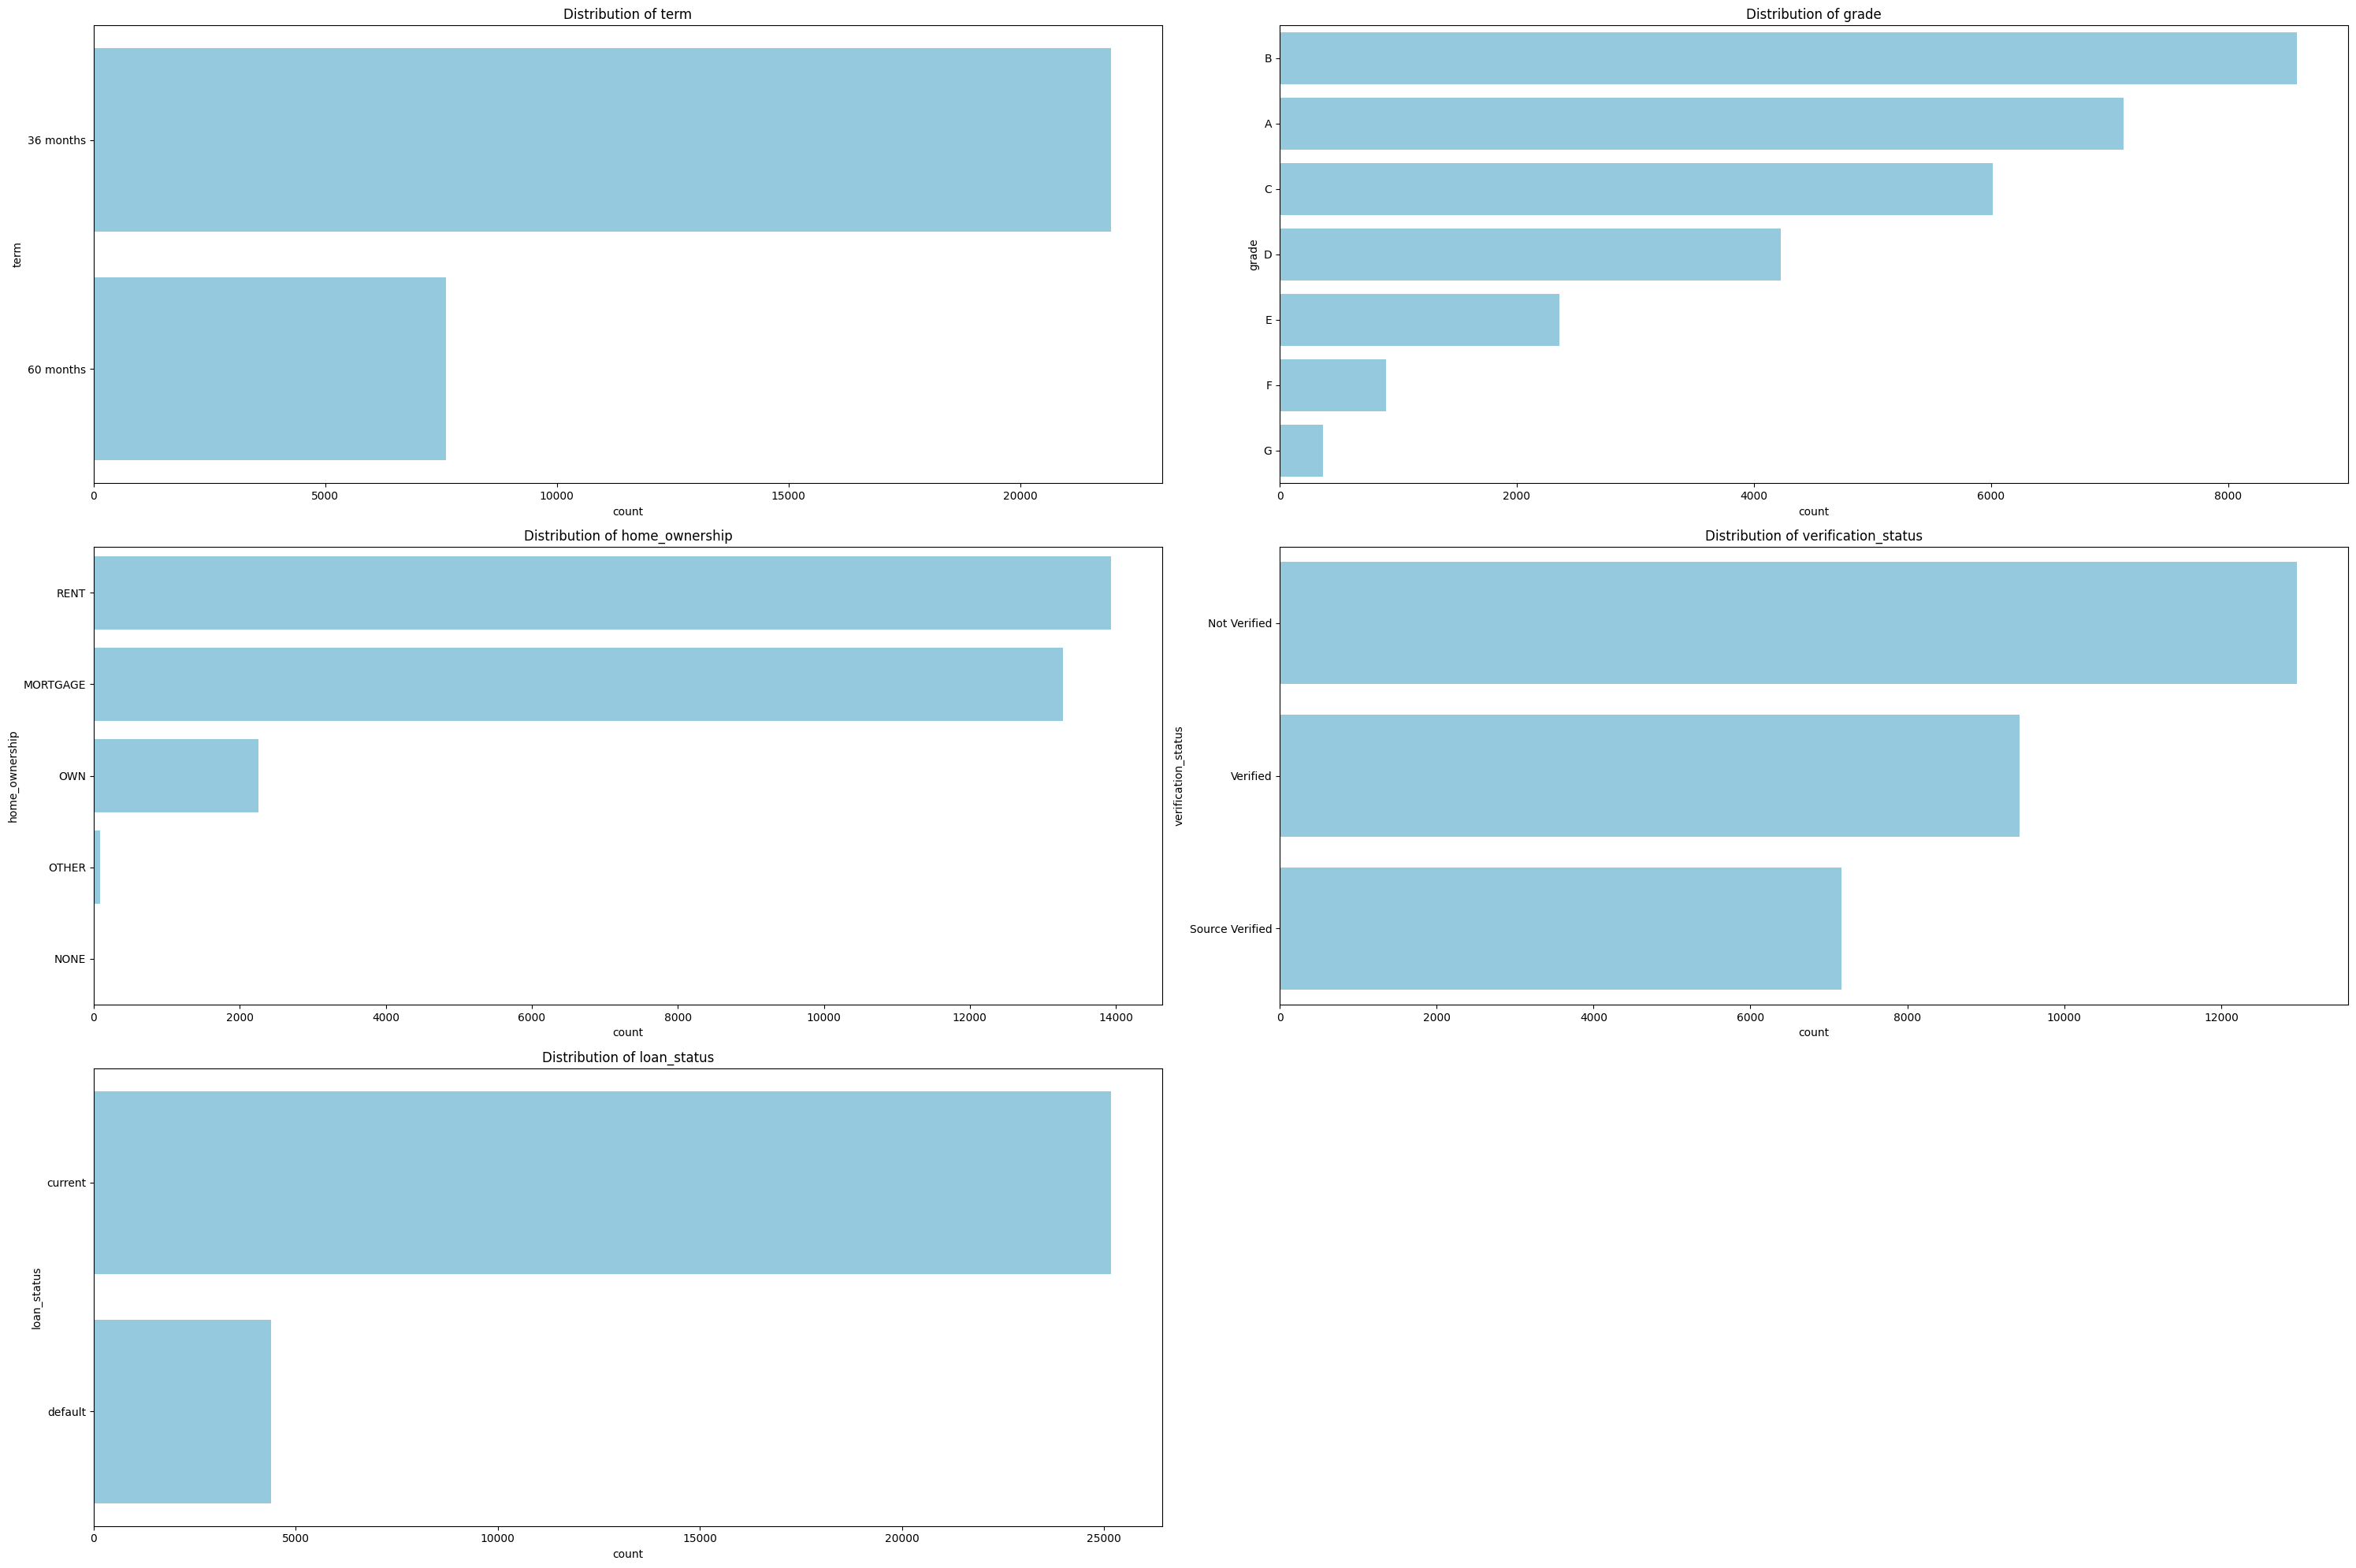

In [1043]:
ynk.visualize_categorical(df, low_card, figsize=(30, 20))

Potential transformation needed: home_ownership

`Med Cardinality`

In [1044]:
med_card = ['sub_grade', 'emp_length', 'purpose', 'addr_state']

sub_grade
B3    7.05%
A4     6.9%
A5     6.6%
B5     6.5%
B4    5.95%
C1    5.38%
B2    5.01%
C2    4.89%
B1    4.52%
A3     4.2%
C3    3.95%
A2    3.72%
D2    3.61%
C4    3.15%
D3    3.09%
C5    2.98%
D4     2.7%
A1    2.66%
D1     2.5%
D5    2.41%
E1    2.05%
E2    1.86%
E3    1.59%
E4    1.31%
E5    1.18%
F1    0.92%
F2     0.7%
F3    0.59%
F4    0.48%
F5    0.34%
G1    0.34%
G4    0.25%
G2    0.24%
G5    0.21%
G3     0.2%
Name: proportion, dtype: object


emp_length
10+ years    22.77%
< 1 year     11.92%
2 years      11.42%
3 years      10.39%
4 years       8.83%
1 year         8.7%
5 years       8.43%
6 years       5.81%
7 years        4.5%
8 years       3.88%
9 years       3.35%
Name: proportion, dtype: object


purpose
debt_consolidation    46.53%
credit_card           12.93%
other                 10.36%
home_improvement       7.48%
major_purchase         5.52%
small_business         4.66%
car                    3.77%
wedding                2.36%
medical                1.78%
mo

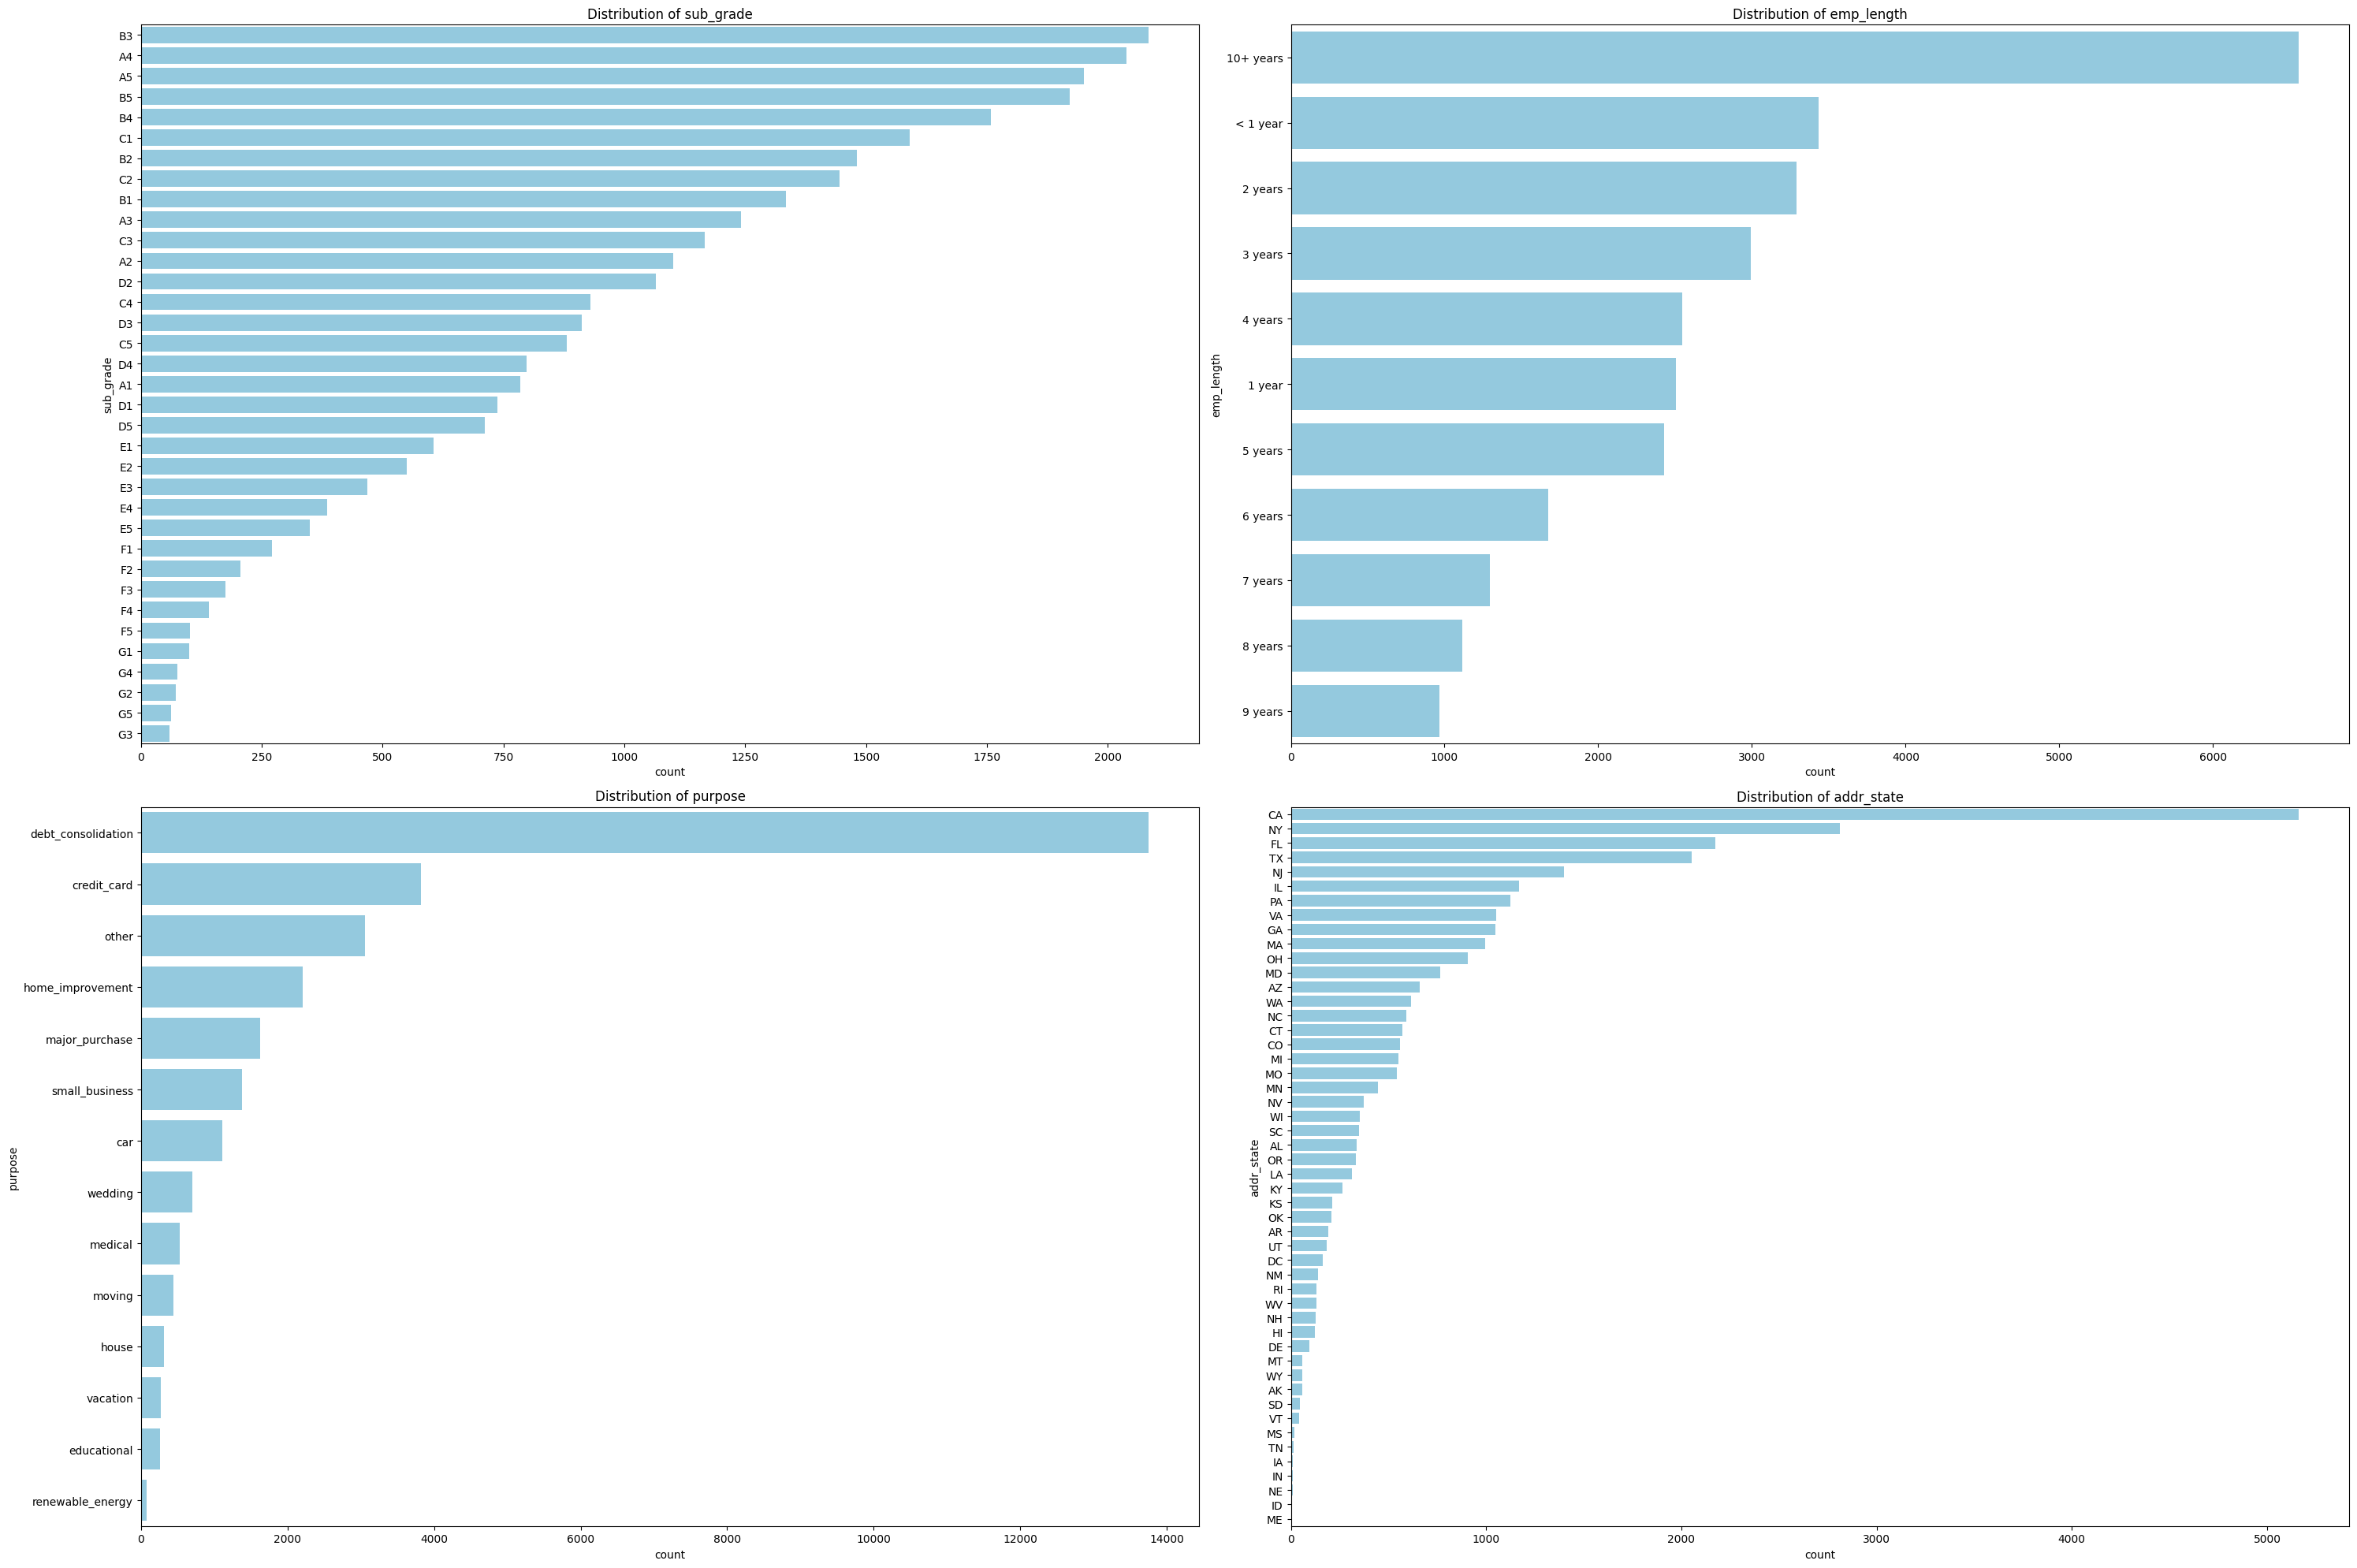

In [1045]:
ynk.visualize_categorical(df, med_card, figsize=(30, 20))

`Large Cardinality `

In [1046]:
large_card = ['issue_d', 'desc', 'earliest_cr_line', 'next_pymnt_d', 'last_credit_pull_d', 'emp_title']

In [1047]:
# unique values in these features
for col in large_card:
    print(f"{col}: {df[col].nunique()}")

issue_d: 53
desc: 20151
earliest_cr_line: 516
next_pymnt_d: 95
last_credit_pull_d: 106
emp_title: 21998


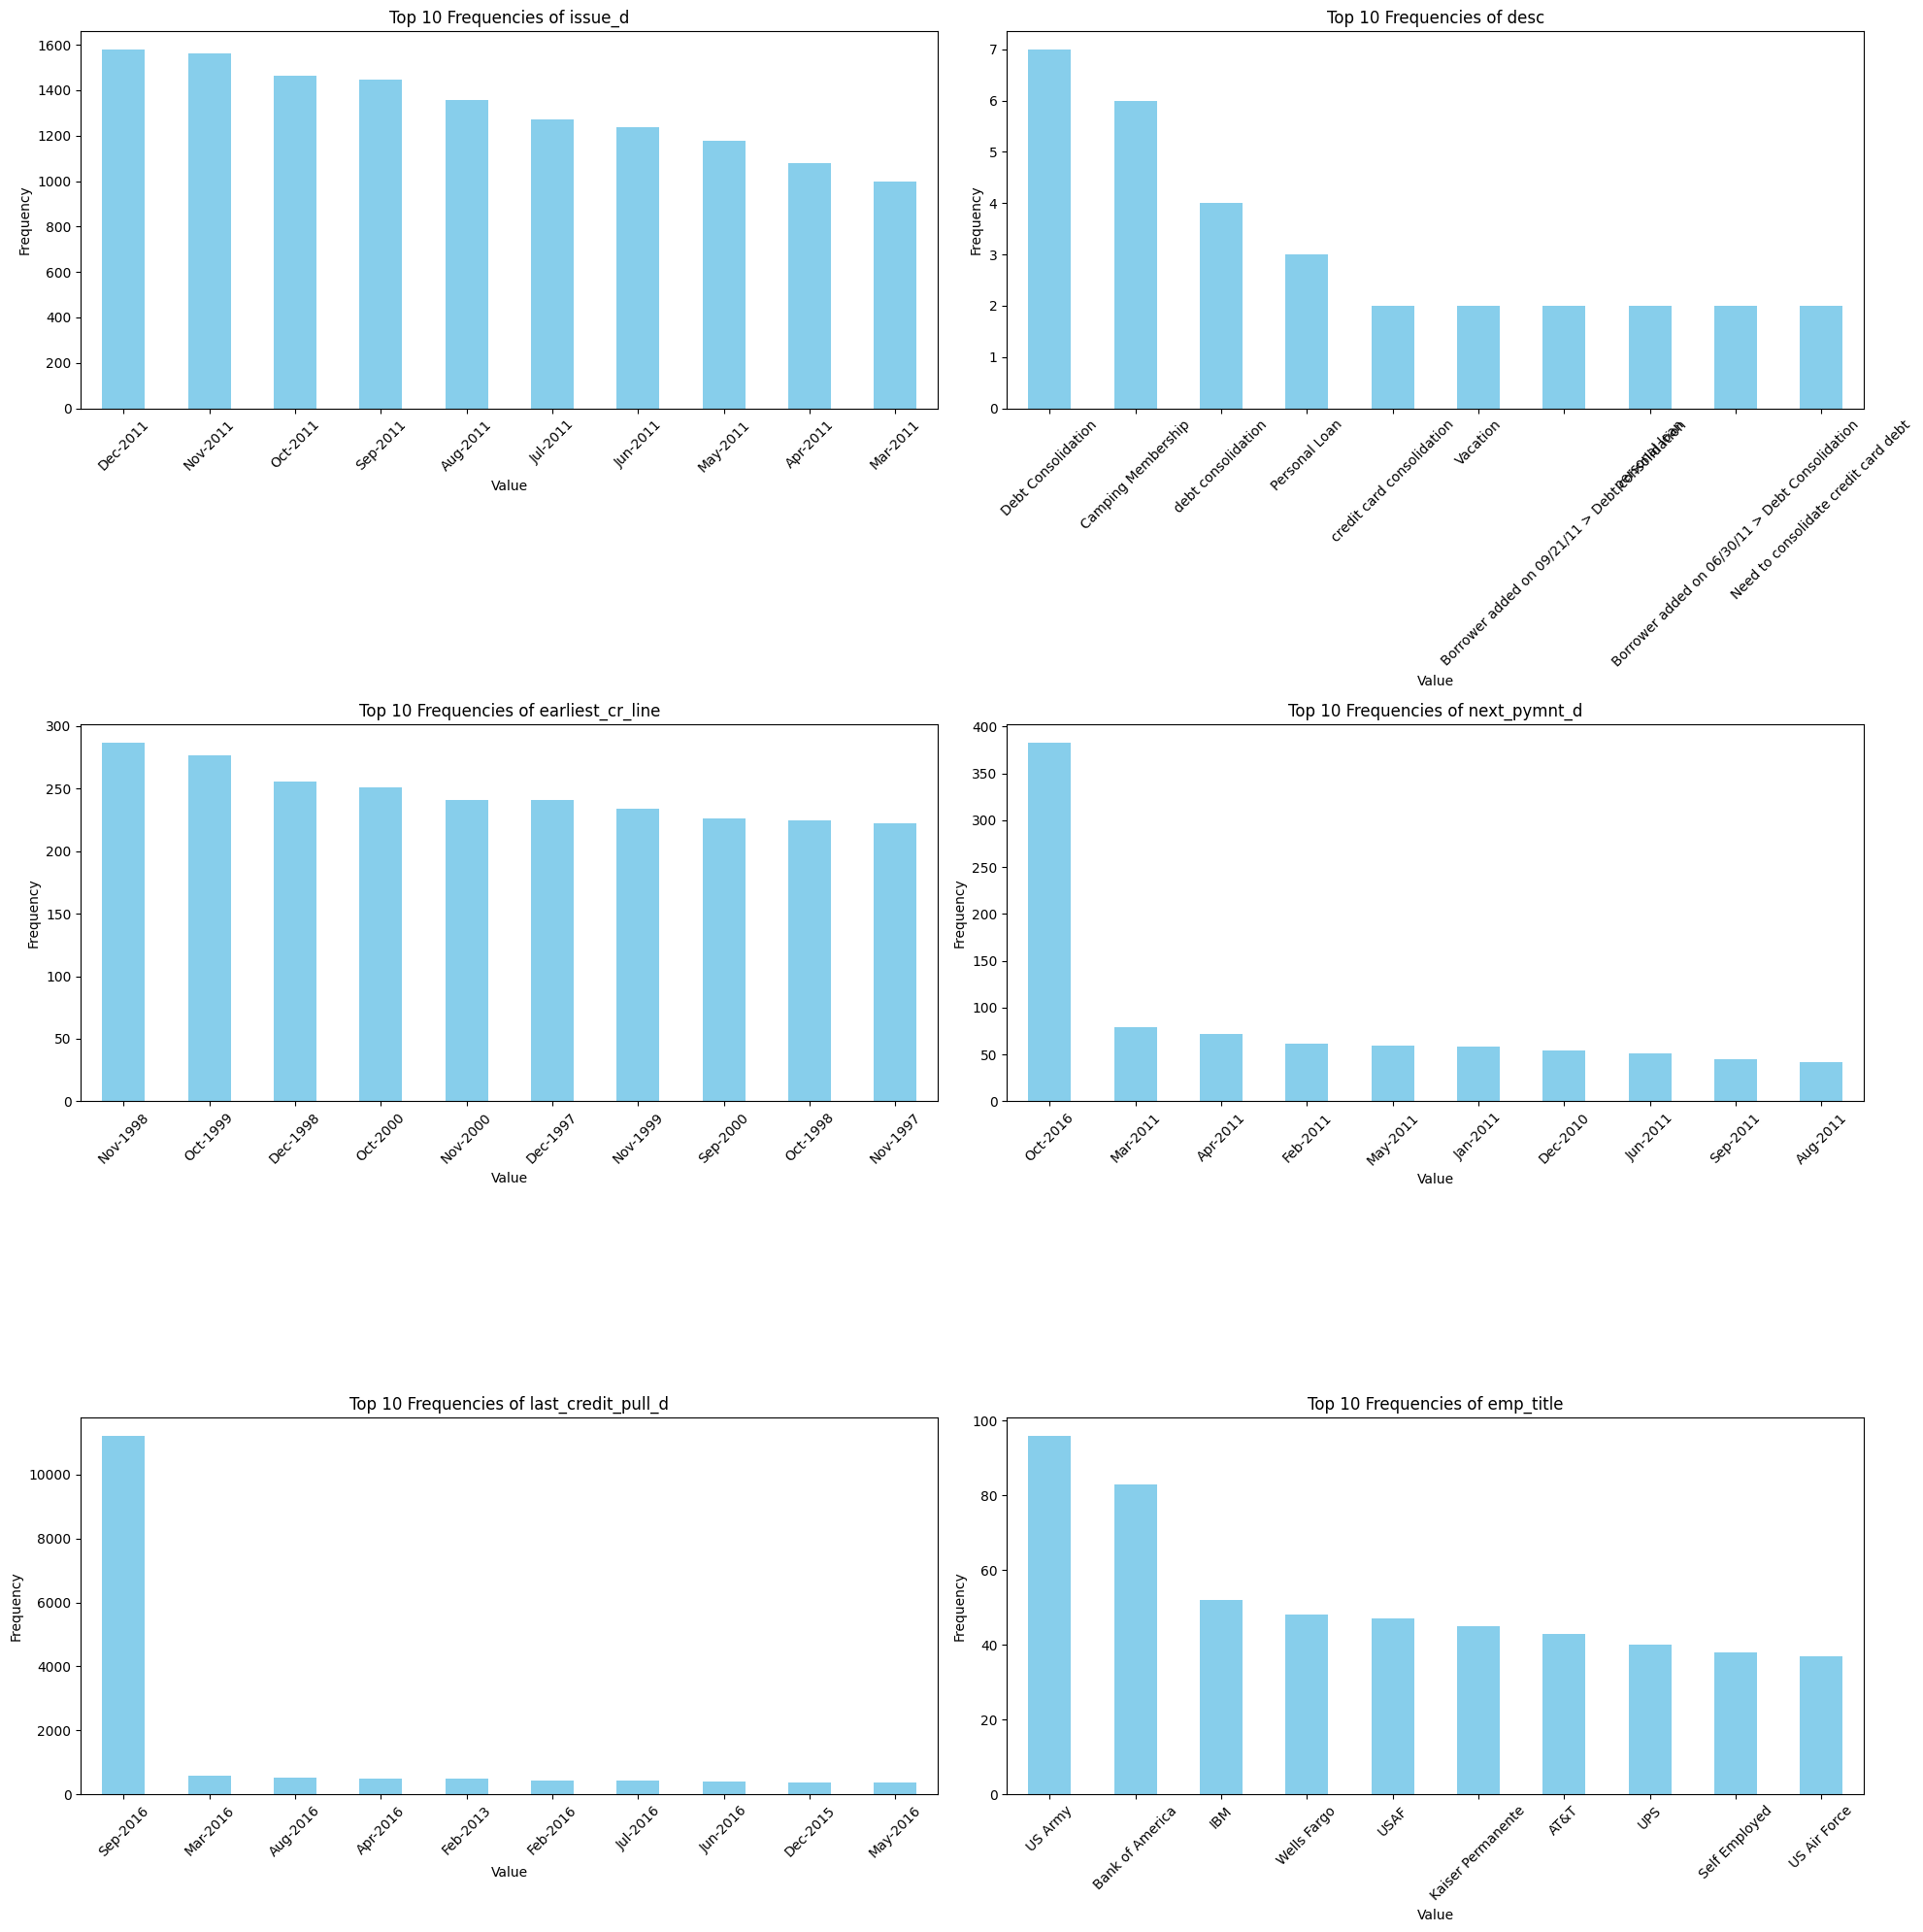

In [1048]:
ynk.plot_top_10_frequencies(df, large_card)

The majority of title is debt consolidation and debt consolidation loan. On the other hand, Oct 2016 is the most frequent next_pymnt_d. Also, an overwhelming majority of last_credit_pull_d is Sep 2016

## I.3 Bivariate Analysis

Explore the relationship between the target variable (loan_status) and other features

In [1049]:
# update numerical feature list 
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()

The distribution between target variabel and other numerical features is quite similar. However, we can still spot a few difference. For example, the median interest rate for default loan is slightly higher than that of current loan. Meanwhile, fico_range_high is lower for default loan than that of current loan 

`Numerical Features and Target Variable`

In [1050]:
# ynk.plot_boxplot_and_histogram(df, numerical_features, 'loan_status')

`Categorical Features and Target Variable`

Low Cardinality

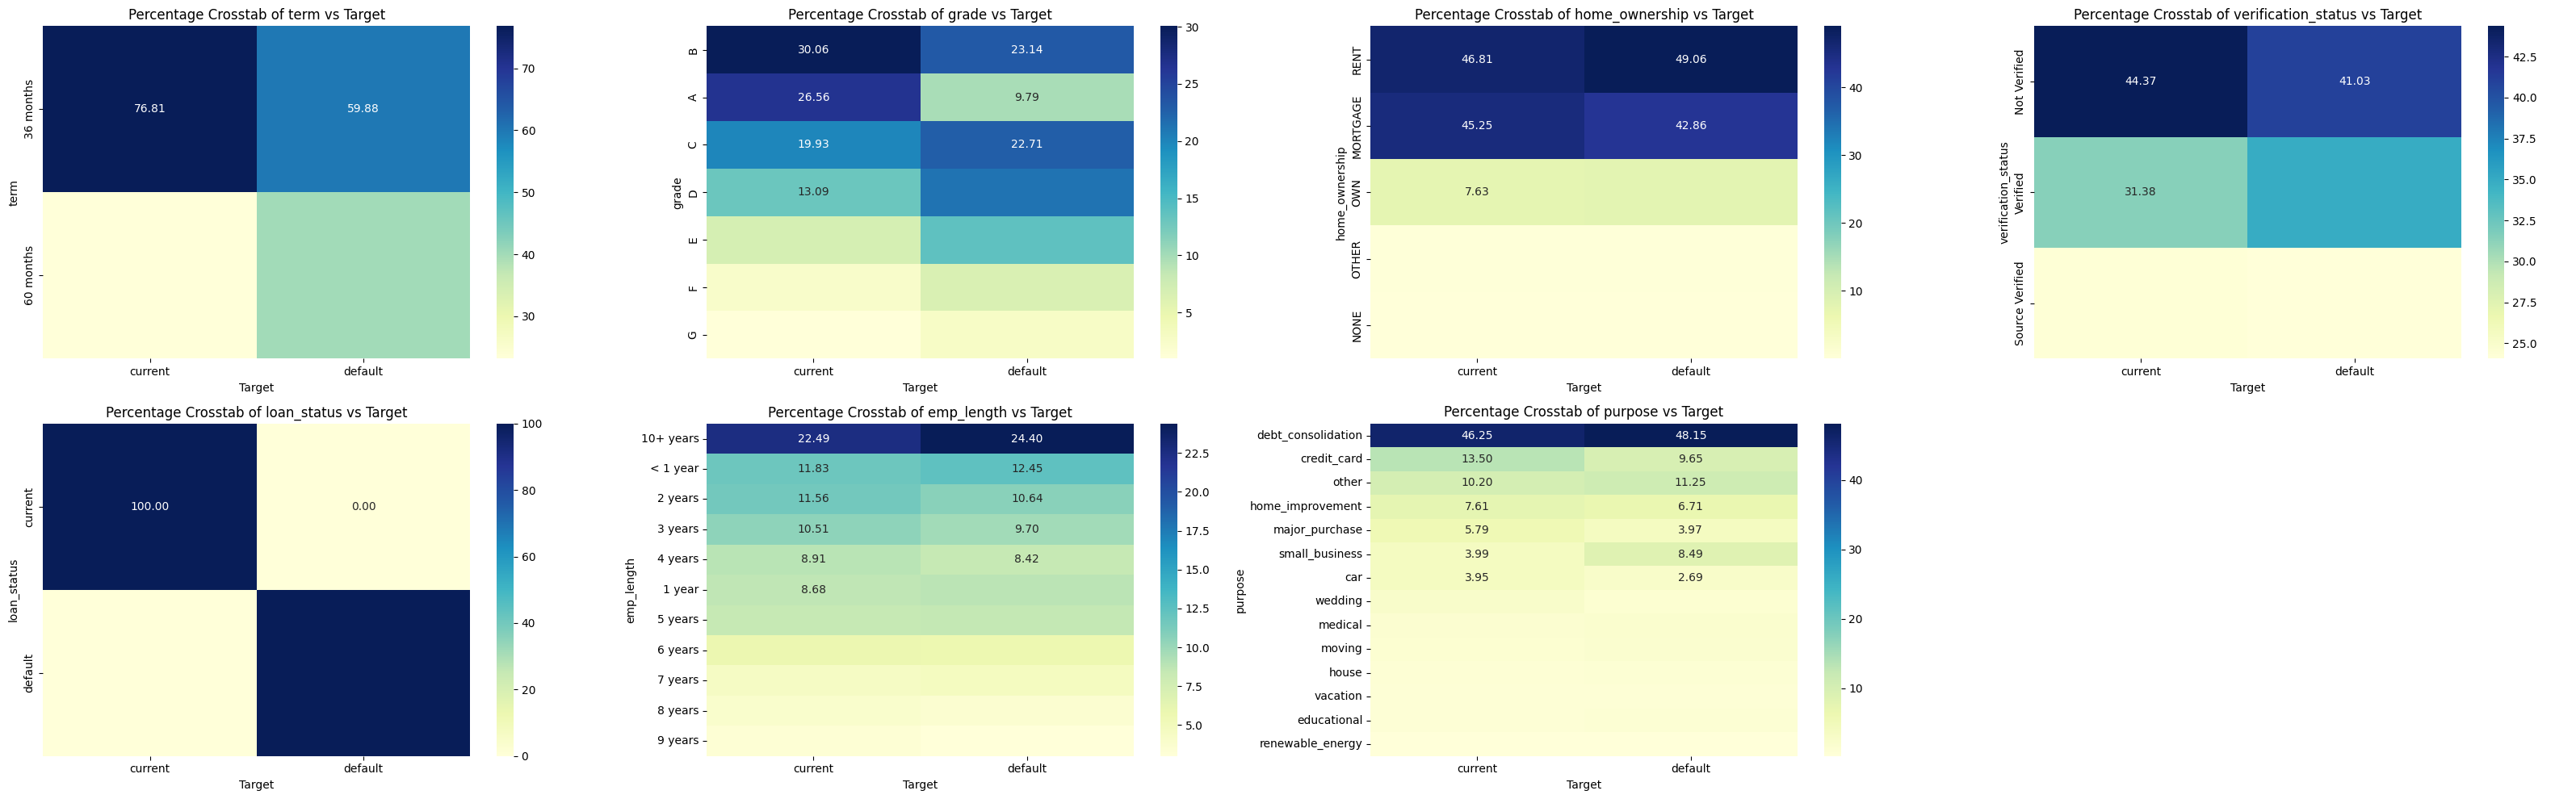

In [1051]:
ynk.plot_percentage_crosstab(df, df['loan_status'], low_card + ['emp_length','purpose'])

## I.4 Multivariate Analysis

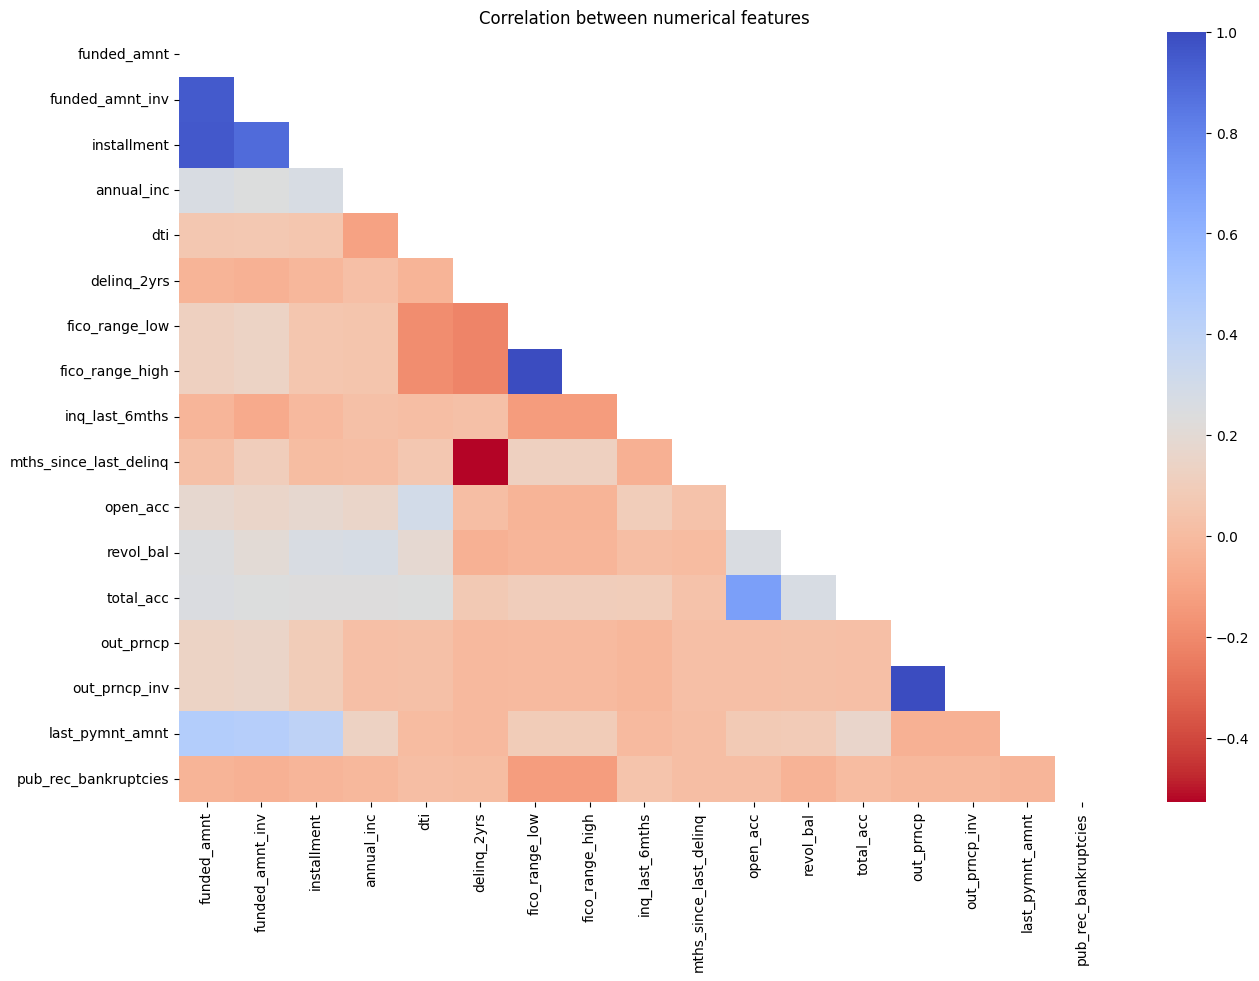

In [1052]:
# check the correlation between numerical features
correlation = df[numerical_features].corr()

plt.figure(figsize=(15, 10))
mask = np.zeros_like(correlation, dtype=bool)
mask[np.triu_indices_from(mask)] = True  # Mask the upper triangle
sns.heatmap(correlation, annot=True, cmap='coolwarm_r', mask=mask)
plt.title('Correlation between numerical features')
plt.show()

Some numerical features are highly correlated with one another. We can consider removing some of them to avoid multicollinearity

# II. Feature Engineering

In [1053]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('loan_status', axis=1), df['loan_status'], test_size=0.2, random_state=42)

In [1054]:
# get the data ready for model building
X_train = dp.feature_engineering_pipeline(X_train)

X_test = dp.feature_engineering_pipeline(X_test)

y_train = dp.convert_target_to_numerical(y_train)

y_test = dp.convert_target_to_numerical(y_test)


# III. Model Building 

In [1055]:
# update numerical and categorical features list 
numerical_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(include=[object]).columns.tolist()


In [1056]:
# Create a pipeline to preprocess the data 
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# combine
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


## III. 1 Logisitic Regression

In [1057]:
# execute the pipeline
lr_pipeline = ynk.train_model(LogisticRegression(random_state=0), preprocessor,  X_train, y_train)

# obtain prediction 
lr_pred, lr_pred_prob = ynk.get_predictions(lr_pipeline, X_test)

# obtain performance 
lr_performance = PerformanceMetrics(y_test, lr_pred, lr_pred_prob)

# print out the performance
lr_performance.print_performance_metrics('Logistic Regression')

Performance Metrics of the model Logistic Regression: 

Accuracy: 0.9134
Precision: 0.7438
Recall: 0.6596
ROC AUC: 0.9483
F1 Score: 0.6992


## III. 2 Random Forest

In [1058]:
# execute the pipeline
rf_pipeline = ynk.train_model(RandomForestClassifier(random_state=0), preprocessor,  X_train, y_train)

# obtain prediction 
rf_pred, rf_pred_prob = ynk.get_predictions(rf_pipeline, X_test)

# obtain performance 
rf_performance = PerformanceMetrics(y_test, rf_pred, rf_pred_prob)

# print out the performance
rf_performance.print_performance_metrics('Base Random Forest')

Performance Metrics of the model Random Forest: 

Accuracy: 0.9010
Precision: 0.8042
Recall: 0.4645
ROC AUC: 0.9473
F1 Score: 0.5889


## III. 3 XGBoost

In [1062]:
# execute the pipeline
xgb_pipeline = ynk.train_model(XGBClassifier(random_state=0), preprocessor,  X_train, y_train)

# obtain prediction 
xgb_pred, xgb_pred_prob = ynk.get_predictions(xgb_pipeline, X_test)

# obtain performance 
xgb_performance = PerformanceMetrics(y_test, xgb_pred, xgb_pred_prob)

# print out the performance
xgb_performance.print_performance_metrics('Base XGBoost')

Performance Metrics of the model Base XGBoost: 

Accuracy: 0.9212
Precision: 0.7633
Recall: 0.7007
ROC AUC: 0.9568
F1 Score: 0.7306
